In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import os

import gsw
#import gsw_xarray as gsw # Wrapper for gsw that adds CF attributes
from wmt_inert_tracer.preprocessing import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

Schmidtko et al. (2014): 
**ASBW** is defined using the deepest measurement in profiles within *30 m* of the bottom, or, in the absence of CTD altimeter data, within 150m of the ETOPO-1 bathymetry. **ASBW** data are mapped onto a 0.25$^{\circ}\times$0.125$^{\circ}$ grid for bathymetry shallower than *1500 m*.

In [2]:
deptho_max = 1500
north = -60.0

In [3]:
mod = 'ESM4' # CM4, ESM4, OM4p25, OM4p5, OM4p125
exp = 'piControl' # piControl, historical, abrupt4xCO2, 1pctCO2, ssp585, ssp245
# piControl_c192, CORE, JRA55do1.4_0netfw, JRA55do1.4_mle3d, 2010Control
mem = None # None, D1, D151, D201, 251, 290, 332
idn = None # None, md805, md802
#cyl = 1
app = 'spinupB' # '', extradiags_v3, spinupB, noBling, noBLING, noBLING_fresh

frq = 'annual' # monthly, annual
tprd = '*'

In [4]:
outdir='/work/jet/data/interim/'
rootdir = '/home/Jan-erik.Tesdal/data/raw/'

if mod=='CM4':
    if exp in ['piControl','abrupt4xCO2','1pctCO2']:
        subdir = mod+'_'+exp+'_C'
    elif exp=='piControl_c192':
        subdir = mod+'_'+exp+'_OM4p25'
    elif exp=='2010Control':
        if idn=='md805':
            subdir = mod+'_c96L33_am4p0_2010_base_mp5_kvs05_ep'
        elif idn=='md802':
            subdir = mod+'_c96L33_am4p0_2010_base_mp5_kvs05'
    elif exp in ['ssp585','ssp245']:
        if mem:
            if  mem!='251':
                subdir = mod+'_'+exp+'_'+app+'_'+mem if len(app)>0 else mod+'_'+exp+'_'+mem
            else:
                subdir = mod+'_Scenario_'+exp
                if len(app)!=0:
                    subdir = subdir+'_'+app
        else:
            subdir = mod+'_Scenario_'+exp
            if len(app)!=0:
                    subdir = subdir+'_'+app
    elif exp=='historical':
        if mem:
            if  mem!='251':
                subdir = mod+'_'+exp+'_'+app+'_Run895Rst'+mem if len(app)>0 else mod+'_'+exp+'_Run895Rst'+mem
            else:
                subdir = mod+'_'+exp
        else:
            subdir = mod+'_'+exp
    else:
        subdir = mod+'_'+exp
elif mod=='ESM4':
    if exp=='piControl':
        if len(app)>0:
            subdir = mod+'_'+exp+'_'+app
        else:
            subdir = mod+'_'+exp+'_D'
    elif exp in ['piControl','historical','1pctCO2','ssp585']:
        subdir = mod+'_'+exp+'_'+mem
        
    else:
        subdir = mod+'_'+exp[:6]+'-'+exp[-5:]+'_D1'
elif mod=='OM4p25':
    if exp=='CORE':
        subdir = mod+'_IAF_BLING_CFC_csf'
    else:
        if len(app)==0:
            subdir = mod+'_'+exp+'_cycle'+str(cyl) if cyl>1 else mod+'_'+exp
        else:
            subdir = mod+'_'+exp+'_cycle'+str(cyl)+'_'+app
elif mod=='OM4p5':
    subdir = mod+'_IAF_BLING_CFC_abio_csf_mle200'
    
pp = 'ocean_annual_z'
full_path = os.path.join(rootdir,subdir,pp)
if 'cyl' in locals():
    if cyl>1:
        head = subdir if (mod=='OM4p25') & (exp!='CORE') else '%s_%s'%(mod,exp)
    else:
        head = subdir+'_cycle'+str(cyl)
else:        
    if mem:
        if mod=='CM4':
            head = '%s_%s_%s_%s'%(mod,exp,app,mem) if len(app)>0 else '%s_%s_%s'%(mod,exp,mem)
        elif mod=='ESM4':
            head = subdir
        else:
            head = subdir
    elif idn:
        head = '%s_%s_%s'%(mod,exp,idn)
    else:
        if (mod=='CM4') & (exp=='piControl'):
            head = 'CM4_piControl_C'
        elif subdir == 'CM4_Scenario_ssp585_noBLING_fresh':
            head = '%s_%s_melt'%(mod,exp)
        elif subdir == 'CM4_Scenario_ssp585_noBLING':
            head = '%s_%s_nomelt'%(mod,exp)
        else:
            head = '%s_%s'%(mod,exp)

print(head+':',full_path)

ESM4_piControl: /home/Jan-erik.Tesdal/data/raw/ESM4_piControl_spinupB/ocean_annual_z


In [5]:
var = 'so'
print('dmls -lah `readlink -f ',full_path+'/'+pp+'.*.%s.nc'%var+'`')
print('dmget `readlink -f ',full_path+'/'+pp+'.*.%s.nc'%var+'`','&')

dmls -lah `readlink -f  /home/Jan-erik.Tesdal/data/raw/ESM4_piControl_spinupB/ocean_annual_z/ocean_annual_z.*.so.nc`
dmget `readlink -f  /home/Jan-erik.Tesdal/data/raw/ESM4_piControl_spinupB/ocean_annual_z/ocean_annual_z.*.so.nc` &


In [6]:
vars_ds = xr.open_mfdataset(full_path+'/'+pp+'.*.%s.nc'%var,use_cftime=True,
                            drop_variables=['average_DT','average_T1','average_T2'])

In [7]:
pp = 'ocean_monthly'
if mod in ['CM4','OM4p25']:
    grid_ds = xr.open_dataset(rootdir+'CM4_piControl_C/'+pp+'/'+pp+'.static.nc')
elif mod in ['ESM4','OM4p5']:
    grid_ds = xr.open_dataset(rootdir+'ESM4_piControl_D/'+pp+'/'+pp+'.static.nc')
else:
    print('grid is not available for '+subdir)

In [8]:
pd.concat([vars_ds.xh.to_series().reset_index(drop=True), 
           grid_ds.xh.to_series().reset_index(drop=True), 
           grid_ds.xq.to_series().reset_index(drop=True)], axis=1)

,xh,xh,xq
0,-299.75,-299.75,-299.5
1,-299.25,-299.25,-299.0
2,-298.75,-298.75,-298.5
3,-298.25,-298.25,-298.0
4,-297.75,-297.75,-297.5
...,...,...,...
715,57.75,57.75,58.0
716,58.25,58.25,58.5
717,58.75,58.75,59.0
718,59.25,59.25,59.5


In [9]:
ds = preprocessing(vars_ds, grid_ds, decode_times=False, verbose=False)

In [10]:
teos10=True # to calculate absolute salinity

In [11]:
if teos10:
    print('Calculate TEOS-10 Absolute salinity')
    p = xr.apply_ufunc(gsw.p_from_z, -ds['lev'], ds['lat'], 0, 0, dask='parallelized')
    sa = xr.apply_ufunc(gsw.SA_from_SP, ds.so, p, ds['lon'], ds['lat'], dask='parallelized')
    sab = sa.chunk({'time':1}).ffill('lev').isel(lev=-1).where(ds.lat<north).where(ds.deptho<deptho_max).rename(var)
else:
    sab = ds[var].chunk({'time':1}).ffill('lev').isel(lev=-1).where(ds.lat<north).where(ds.deptho<deptho_max)

Calculate TEOS-10 Absolute salinity


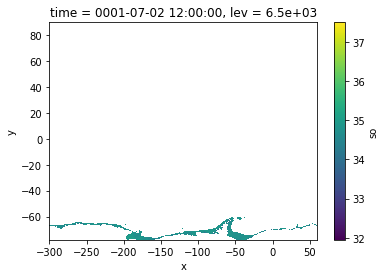

In [12]:
sab[0].plot()

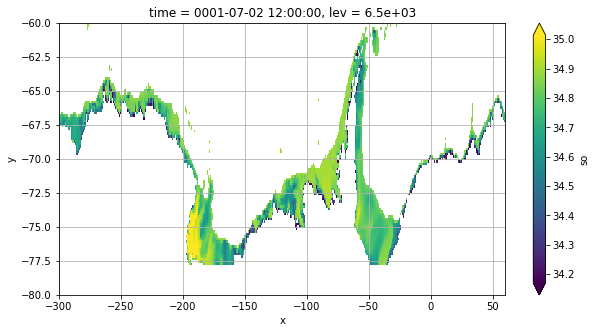

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
sab[0].where(ds.wet==1).plot(ax=ax,x='x',y='y',robust=True)
ax.set_ylim([-80, -60])
ax.grid(True)
plt.show()

In [14]:
# 0.125
#sab_obs = xr.open_dataset('/work/jet/Schmidtko_Antarctic_shelf_data_bottom_salinity_0125.nc').bottom_so

# 0.25
#sab_obs = xr.open_dataset('/work/jet/Schmidtko_Antarctic_shelf_data_bottom_salinity_025.nc').bottom_so

# 0.5
sab_obs = xr.open_dataset('/work/jet/Schmidtko_Antarctic_shelf_data_bottom_salinity_05.nc').bottom_so

In [15]:
from dask.diagnostics import ProgressBar

with ProgressBar():
    sab_t0 = sab.where(sab_obs.notnull())[0].load()

[########################################] | 100% Completed |  1.6s


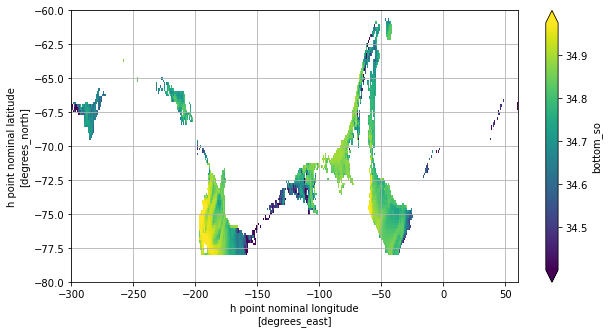

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
sab_obs.plot(ax=ax,x='x',y='y',robust=True)
ax.set_ylim([-80, -60])
ax.grid(True)
plt.show()

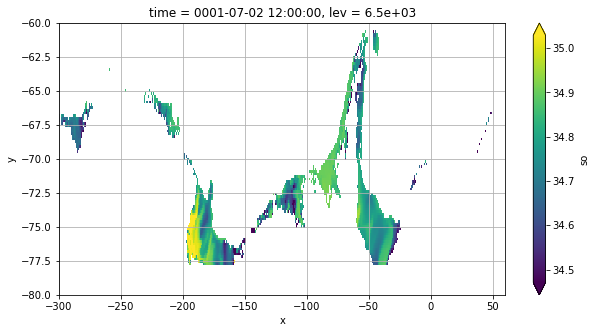

In [17]:
fig, ax = plt.subplots(figsize=(10,5))
sab_t0.where(ds.wet==1).plot(ax=ax,x='x',y='y',robust=True)
ax.set_ylim([-80, -60])
ax.grid(True)
plt.show()

In [18]:
import sys
sys.path.append('/home/Jan-erik.Tesdal/wmt-inert-tracer/scripts/tools')
from compute import horizontal_mean

In [19]:
with ProgressBar():
    sab_so = horizontal_mean(sab.where(sab_obs.notnull()),ds).load()

[########################################] | 100% Completed |  3min  8.0s


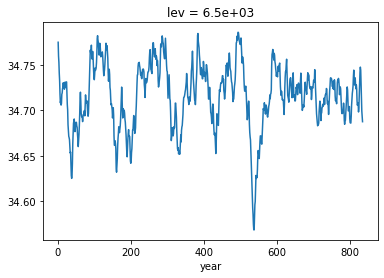

In [20]:
sab_so.groupby('time.year').mean('time').plot()

In [22]:
head = head+'_spinupB'

In [23]:
fname = head+'_%sto%s_sab_onshlf.nc'%(str(ds.time.dt.year[0].values).rjust(4, '0'),
                                      str(ds.time.dt.year[-1].values).rjust(4, '0'))
print('Saving to file:', fname)
sab_so.reset_coords(drop=True).to_dataset(name='bottom_sa').to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: ESM4_piControl_spinupB_0001to0835_sab_onshlf.nc


### Plot

In [33]:
from datetime import timedelta

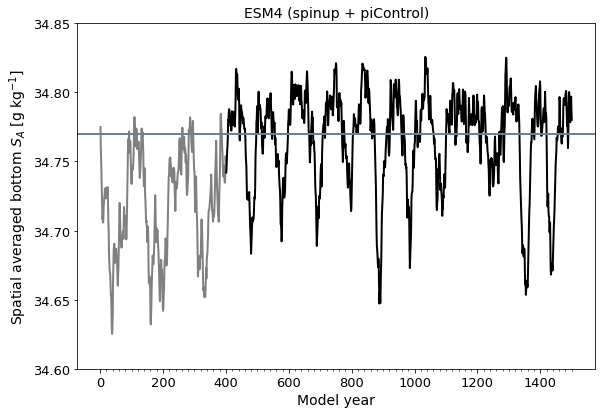

In [45]:
fname1 = 'ESM4_piControl_spinupB_0001to0835_sab_onshlf.nc'
fname2 = 'ESM4_piControl_0001to1100_sab_onshlf.nc'
ddict = {s:{} for s in [fname1,fname2]}
ddict[fname1] = xr.open_dataset(outdir+fname1).bottom_sa
ddict[fname2] = xr.open_dataset(outdir+fname2).bottom_sa
sab_cm4 = xr.open_dataset(outdir+'CM4_piControl_C_0001to0650_sab_onshlf.nc').bottom_sa

cstr = ['grey','k']

fig, ax = plt.subplots(figsize=(9,6))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
#sab_cm4.groupby('time.year').mean('time').plot(ax=ax,lw=3,c='k',_labels=False,label='CM4-piControl',alpha=0.3)
for i, s in enumerate(ddict):
    da = ddict[s]
    if 'spinup' not in s:
        da['time'] = da.time + timedelta(days=365*400)
    else:
        da = da.sel(time=slice(None,'0400'))
        
    da.groupby('time.year').mean('time').plot(ax=ax,lw=2,c=cstr[i],_labels=False)

ax.tick_params(axis='both', which='major', labelsize=13)
ax.axhline(y=34.77, xmin=0, xmax=1, c = 'slategrey', lw=2.0, ls='-')
ax.set_ylim([34.60, 34.85])
ax.set_ylabel('Spatial averaged bottom $S_{A}$ [g kg$^{-1}$]',fontsize=14)
ax.set_xticks(np.arange(0,1520,20), minor=True)
ax.set_xlabel(r'Model year',fontsize=14)
ax.set_title('ESM4 (spinup + piControl)', fontsize=14)
plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

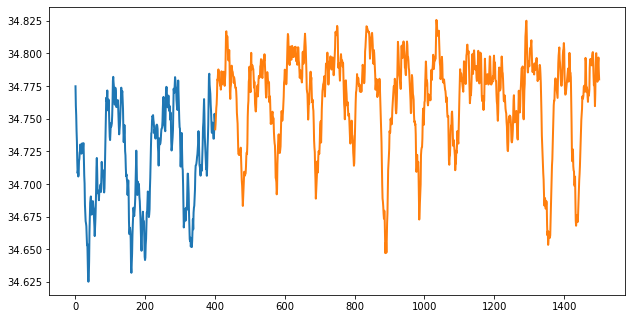

In [ ]:

        
    
        
    ymax = psi.sel(sigma2=slice(36.85,None)).max(dim='sigma2').groupby('time.year').mean('time')
    
    ymax.plot(ax=ax,c=cstr[i],lw=1,alpha=0.3,_labels=False)
    ymax.rolling(year=10,center=True).mean().plot(ax=ax,c=cstr[i],lw=2,_labels=False,ls='-',label=s)

#ax.legend(frameon=True, fancybox=True, bbox_to_anchor=(1.0, 1.0), loc='upper right', ncol=5, fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_ylabel('$-\psi_{AABW}$ at 30$^{\circ}$S [Sv] (offline, hires)', fontsize=14)
ax.set_xticks(np.arange(0,1520,20), minor=True)
ax.set_xlabel(r'Model year',fontsize=14)
ax.set_title('ESM4 (spinup + piControl)', fontsize=14)
plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [7]:
import glob

Loading /work/jet/data/interim/CM4_ssp585_251_2015to2100_sab_onshlf.nc
ERROR: No file for CM4_ssp585_290
ERROR: No file for CM4_ssp585_332
Loading /work/jet/data/interim/CM4_ssp585_melt_2015to2100_sab_onshlf.nc
Loading /work/jet/data/interim/CM4_ssp585_nomelt_2001to2100_sab_onshlf.nc


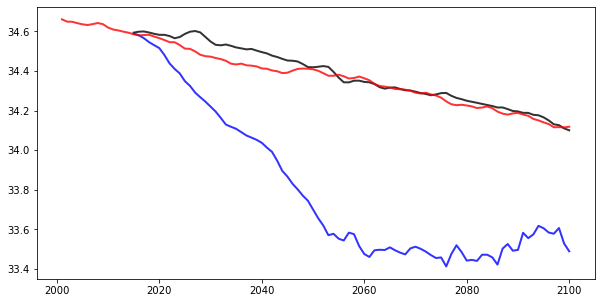

In [24]:
mods = ['CM4_ssp585_251','CM4_ssp585_290','CM4_ssp585_332','CM4_ssp585_melt','CM4_ssp585_nomelt']

cstr = ['k', 'darkgray','slategrey', 'b','r']
lstr = ['ssp585 (251)','ssp585 (290)','ssp585 (332)', 'ssp585+melt','ssp585 (ctrl)']
fig, ax = plt.subplots(figsize=(10,5))

for i, mod in enumerate(mods):
    files = glob.glob(outdir+'%s_*_sab_onshlf.nc'%mod)
    if len(files)>1:
        print('WARNING: More than one zarr directory for '+mod)
    elif len(files)==0:
        print('ERROR: No file for '+mod)
        continue
    
    print('Loading', files[0])
    da = xr.open_dataset(files[0]).bottom_sa.groupby('time.year').mean('time')
    da.plot(ax=ax,c=cstr[i],lw=2,alpha=0.8,_labels=False, label=lstr[i])
plt.show()

In [28]:
fname1 = 'CM4_piControl_0001to0650_sab_onshlf.nc'
fname2 = 'CM4_piControl_doublediff_0386to0405_sab_onshlf.nc'
ddict = {s:{} for s in [fname1,fname2]}
ddict[fname1] = xr.open_dataset(outdir+fname1).bottom_sa
ddict[fname2] = xr.open_dataset(outdir+fname2).bottom_sa

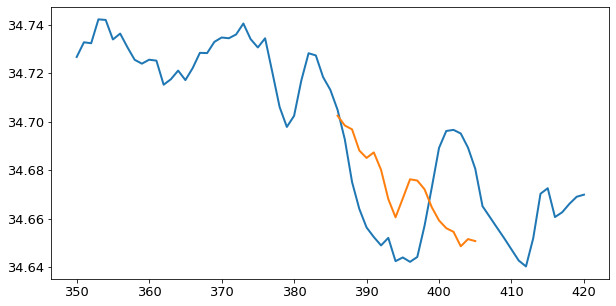

In [32]:
fig, ax = plt.subplots(figsize=(10,5))
for s in [fname1,fname2]:
    ddict[s].groupby('time.year').mean('time').sel(year=slice(350,420)).plot(ax=ax,lw=2,_labels=False)

ax.tick_params(axis='both', which='major', labelsize=13)

plt.show()

In [9]:
fnamea = 'CM4_historical_251_1850to2014_sab_onshlf.nc'

#fnamea1 = 'ESM4_historical_D1_1850to2014_sab_onshlf.nc'
#fnamea2 = 'ESM4_historical_D151_1850to2014_sab_onshlf.nc'
#fnamea3 = 'ESM4_historical_D201_1850to2014_sab_onshlf.nc'

fnameb = 'OM4p25_JRA55do1.4_0netfw_cycle6_extradiags_v3_1958to2017_sab_onshlf.nc'
fnamec = 'OM4p25_CORE_1708to2007_sab_onshlf.nc'
fnamed = 'OM4p5_CORE_1708to2007_sab_onshlf.nc'

ddict = {s:{} for s in [fnamea,fnameb,fnamec,fnamed]}
ddict[fnamea] = xr.open_dataset(outdir+fnamea).bottom_sa

#ddict = {s:{} for s in [fnamea1,fnamea2,fnamea3,fnameb,fnamec,fnamed]}
#ddict[fnamea1] = xr.open_dataset(outdir+fnamea1).bottom_sa
#ddict[fnamea2] = xr.open_dataset(outdir+fnamea2).bottom_sa
#ddict[fnamea3] = xr.open_dataset(outdir+fnamea3).bottom_sa

ddict[fnameb] = xr.open_dataset(outdir+fnameb).bottom_sa
ddict[fnamec] = xr.open_dataset(outdir+fnamec).bottom_sa
ddict[fnamed] = xr.open_dataset(outdir+fnamed).bottom_sa

In [10]:
print(ddict[fnameb].time[0].dt.year.values)

1958


In [14]:
sab_cm4 = xr.open_dataset(outdir+'CM4_piControl_C_0001to0650_sab_onshlf.nc').bottom_sa.sel(time=slice(None,'0500'))

#The GFDL-CM4 1pctCO2, abrupt-4xCO2, and historical experiments branched from piControl at year 251
# shift time axis so that year 251 becomes year 1849
sab_cm4['time'] = sab_cm4.time + timedelta(days=365*1598)

Similar to the approach used for CM4.0, the historical simulations that were branched off the ESM4.1 piControl run utilize the identical atmospheric and ocean models, but the land model has additional tiles in each grid box representing secondary growth of forest. The land in the historical run was initialized by first executing a branch from prototype piControl of 100 years duration, followed by a 1700–1750 land-only run starting from potential vegetation (no land use) state, and 1750–1849 coupled bridge run, both with full land use transitions to allow the secondary forests to spinup to realistic state of regrowth. The ocean, sea ice, and atmosphere initial conditions were then reset to the conditions at the branch-off time of piControl (e.g., piControl Year 101) to minimize initial differences between piControl and the historical run due to the ocean and sea ice states. In addition to land use, the historical simulations include the time evolving greenhouse gas concentrations (including ozone for radiation calculations), aerosol precursor emissions, and solar irradiance consistent with CMIP6 specifications (documented at http://goo.gl/r8up31). Two additional ensemble members for the historical simulation were branched at Years 151 and 201 of the piControl.

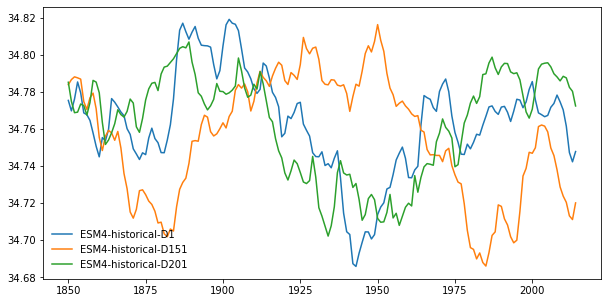

In [54]:
fig, ax = plt.subplots(figsize=(10,5))

for s in [fnamea1,fnamea2,fnamea3]:
    labl = s.split('_')[0]+'-'+s.split('_')[1]+'-'+s.split('_')[2]
    sss_so = ddict[s]
    sss_so.groupby('time.year').mean('time').plot(ax=ax,_labels=False,label=labl)
    
ax.legend(frameon=False, fancybox=False,loc='lower left', ncol=1, fontsize=10)
plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [44]:
sab_esm4 = xr.open_dataset(outdir+'ESM4_piControl_0001to1100_sab_onshlf.nc').bottom_sa.sel(time=slice(None,'0300'))

#The GFDL-ESM4historical experiments branched from piControl at year 101, 151 and 201
# shift time axis so that year 101 becomes year 1849
sab_esm4['time'] = sab_esm4.time + timedelta(days=365*1748)

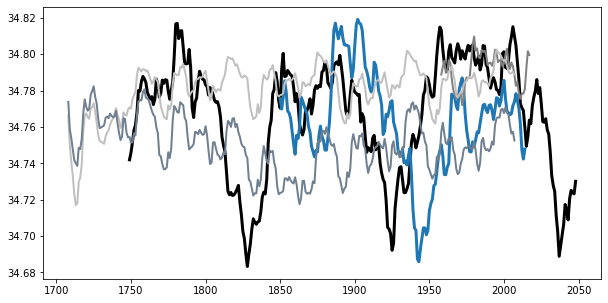

In [49]:
cstr = ['tab:blue','tab:orange','tab:green','grey','silver','slategrey']

fig, ax = plt.subplots(figsize=(10,5))

sab_esm4.groupby('time.year').mean('time').plot(ax=ax,lw=3,c='k',_labels=False,
                                                label='ESM4-piControl')

for i, s in enumerate(ddict):
    if s in [fnamea2,fnamea3]:
        continue
    labl = s.split('_')[0]+'-'+s.split('_')[1]
    #print(labl)
    sss_so = ddict[s]
    sss_so.groupby('time.year').mean('time').plot(ax=ax,lw=3 if s in [fnamea1,fnamea2,fnamea3] else 2,
                                                  c=cstr[i],_labels=False,label=labl)

In [27]:
sab_CM4p125 = xr.open_dataset(outdir+'CM4_piControl_c192_OM4p125_v7_0001to0240_sab_onshlf.nc').bottom_sa

# Start at the same point as CM4 piControl
sab_CM4p125['time'] = sab_CM4p125.time + timedelta(days=365*1598)

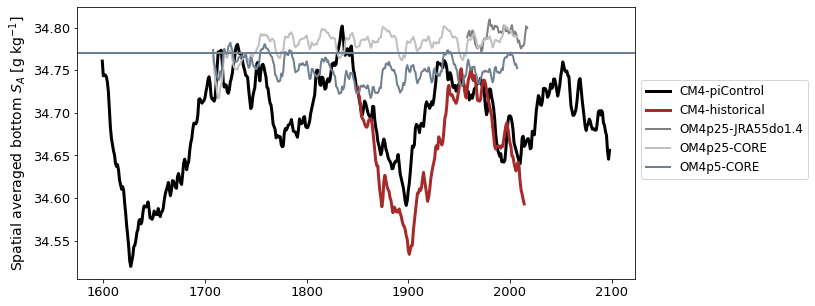

In [15]:
cstr = ['brown','grey','silver','slategrey']

fig, ax = plt.subplots(figsize=(10,5))

sab_cm4.groupby('time.year').mean('time').plot(ax=ax,lw=3,c='k',_labels=False,
                                               label='CM4-piControl')
#sab_CM4p125.groupby('time.year').mean('time').plot(ax=ax,lw=3,c='tab:blue',_labels=False,
#                                               label='CM4-piControl-c192-OM4p125')

for i, s in enumerate(ddict):
    labl = s.split('_')[0]+'-'+s.split('_')[1]
    #print(labl)
    sss_so = ddict[s]
    sss_so.groupby('time.year').mean('time').plot(ax=ax,lw=3 if s in [fnamea] else 2,c=cstr[i],_labels=False,label=labl)
    
ax.axhline(y=34.77, xmin=0, xmax=1, c = 'slategrey', lw=2.0, ls='-')
#ax.legend(frameon=True, fancybox=True,loc='lower left', ncol=1, fontsize=12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.55), frameon=True, fancybox=True, ncol=1, fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_ylabel('Spatial averaged bottom $S_{A}$ [g kg$^{-1}$]',fontsize=14)
plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

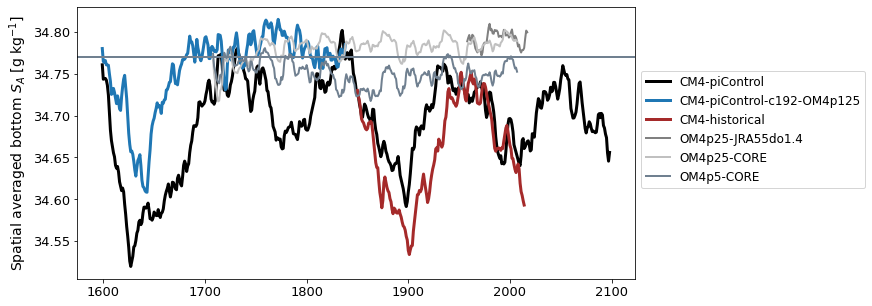

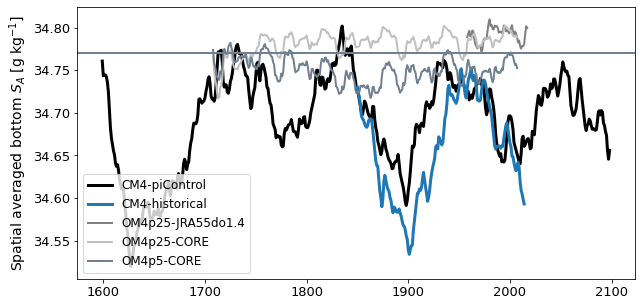

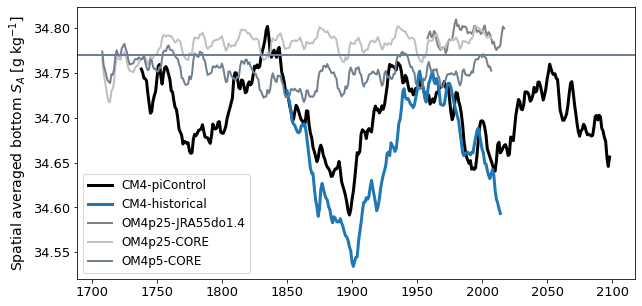

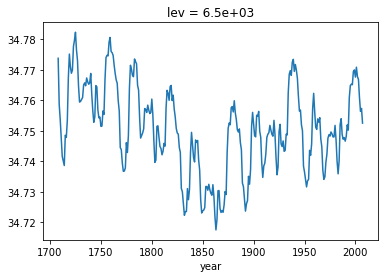

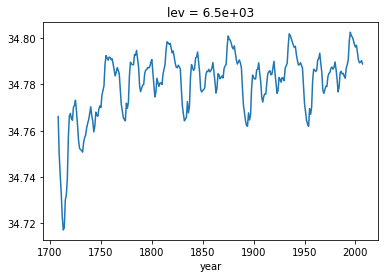

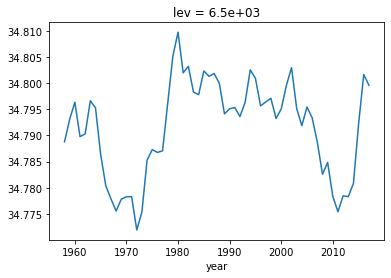

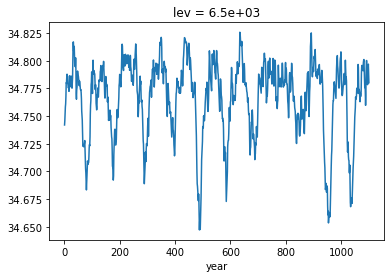

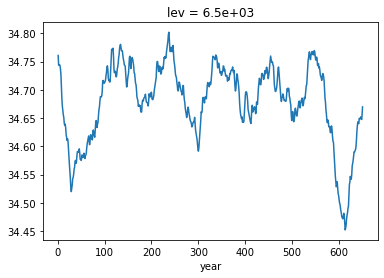